# Generating Latitude and Longitude for projected data

In this notebook you will learn how to:

- open a NetCDF file using `xarray` with `rioxarray` extension;
- explore the coordinate reference system, spatial extent and resolution of the dataset;
- calculate latitudes and longitudes for data in a projected coordinate system;
- find the bounding box and corner coordinates of the dataset in latitude and longitude.

Many datasets at NSIDC are stored in grids that are in a projected coordinate systems (see ref to projected crs) rather than in a geographic coordinate system (e.g. latitude, longitude).  Often only the projected coordinates (in meters and sometimes kilometers) are stored in the files.  This is done to keep file sizes small.  Two 2-dimensional grids are required to store latitudes and longitudes for datasets in a projected CRS.

A number of tools are available in python to work with this kind of data, reproject and transform projected coordinates to geographic coordinates.  This notebook demonstrates two tools available in the python language, `rioxarray` and `rasterio`, and the gdal and proj command line tools.

The [MEaSUREs Calibrated Enhanced-Resolution Passive Microwave Daily EASE-Grid 2.0 Brightness Temperature ESDR, Version 1 (NSIDC-0630) dataset](https://nsidc.org/data/nsidc-0630/versions/1#anchor-1) is used as an example.  These data are stored as CF-compliant NetCDF files and are in the NSIDC EASE-Grid v2 North projection.  The tools and workflows described here work with data in any projection.

In [34]:
from pathlib import Path  # to work with filepaths

import itertools  # To generate corner points of the grid

# To work with NetCDF files, reproject data and perform coordinate transformations
import xarray as xr
import rioxarray  # This is not used directly but makes xarray "geospatially aware"
import rasterio

# Used for plotting
from cartopy import crs as ccrs
import matplotlib.pyplot as plt

# Imported to get versions
import cartopy
import matplotlib

# Set path for example file - change this if you want to work with data store in a different path
DATAPATH = Path('..', 'example_data')
EXAMPLE_FILE = DATAPATH / 'NSIDC-0630-EASE2_N25km-NIMBUS7_SMMR-1980031-18H-M-GRD-JPL-v1.3.nc'  #'NSIDC-0630-EASE2_N25km-F17_SSMIS-2023159-19V-E-GRD-CSU_ICDR-v1.5.nc'

In [33]:
# Print versions of non-standard library packages
for pkg in [xr, rioxarray, rasterio, cartopy, matplotlib]:
    if hasattr(pkg, "__name__") & hasattr(pkg, "__version__"):
        print(f"{pkg.__name__}: {pkg.__version__}")

xarray: 2023.2.0
rioxarray: 0.14.0
rasterio: 1.3.6
cartopy: 0.21.1
matplotlib: 3.7.1


## Using `rioxarray` and `xarray`

`xarray` is a python package that is designed to work with multi-dimensional data arrays.  The `xarray` data structures are modelled on the NetCDF data model.  `rioxarry` is an extension to `xarray` that makes `xarray` geospatially aware.  `rioxarray` uses methods from the `rasterio` package to perform coordinate transformations.  `rioxarray` uses a subset of `rasterio`.  In this tutorial notebook, we also use `rasterio` methods to do some operations not available from `rioxarray`. 

## Open a NetCDF file and explore the coordinate system and spatial extent

By setting `decode_coords='all'` when `rioxarray` has been imported, and if the dataset is CF-compliant, the `grid_mapping` attribute of the data variables is used to set the Coordinate Reference System `crs` coordinate variable.  This variable is used to reproject the data or do other coordinate transformations.  `rioxarray` can also calculate the transform (or GeoTransform), which relates the grid coordinates (rows and columns of the data array) to the map coordinates, and the bounds of the dataset. 

_Note: for the example dataset, several warnings will be raised.  These are not errors and should not (to be confirmed) affect the data._ 

In [3]:
ds = xr.open_dataset(EXAMPLE_FILE, decode_coords='all')
ds

/home/apbarret/anaconda3/envs/nsidc_data_cookbook/lib/python3.11/site-packages/xarray/conventions.py:543: SerializationWarning: variable 'TB' has multiple fill values {60000, 0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/apbarret/anaconda3/envs/nsidc_data_cookbook/lib/python3.11/site-packages/xarray/conventions.py:543: SerializationWarning: variable 'TB_std_dev' has multiple fill values {65534, 65535}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/apbarret/anaconda3/envs/nsidc_data_cookbook/lib/python3.11/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:          (time: 1, y: 720, x: 720)
Coordinates:
  * time             (time) datetime64[ns] 1980-01-31
  * y                (y) float64 8.988e+06 8.962e+06 ... -8.962e+06 -8.988e+06
  * x                (x) float64 -8.988e+06 -8.962e+06 ... 8.962e+06 8.988e+06
    crs              |S1 ...
Data variables:
    TB               (time, y, x) float32 ...
    TB_num_samples   (time, y, x) float32 ...
    TB_std_dev       (time, y, x) float32 ...
    Incidence_angle  (time, y, x) float32 ...
    TB_time          (time, y, x) datetime64[ns] ...
Attributes: (12/72)
    Conventions:                   CF-1.6, ACDD-1.3
    title:                         MEaSUREs Calibrated Passive Microwave Dail...
    product_version:               v1.3
    software_version_id:           0.3.17
    software_repository:           git@bitbucket.org:nsidc/measures-byu.git
    history:                       meas_meta_sir
    ...                            ...
    input_file7:                   80.03106415.hdf                          (...
    input_file8:                   80.03106416.hdf                          (...
    input_file9:                   80.03106417.hdf                          (...
    input_file10:                  80.03106418.hdf                          (...
    input_file11:                  80.03106419.hdf                          (...
    input_data_quality_filtering:  Ref. http://nsidc.org/data/docs/daac/nsidc...

We'll plot the brightness temperature (`TB`) image to check that things look as expected.

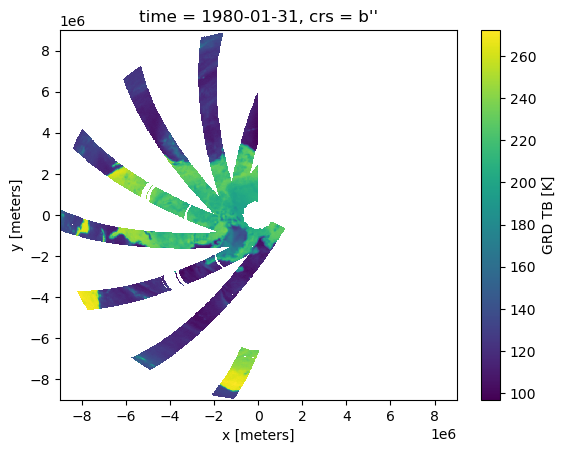

In [4]:
ds.TB[0,:,:].plot()

We can inspect the `crs` variable using the `rio.crs` accessor.  In this case, the EPSG code for the projection `6931` is returned, which is the EPSG code for the WGS 84 version of the NSIDC North Polar Stereographic projection.

In [5]:
ds.rio.crs

CRS.from_epsg(6931)

The Well Known Text (WKT) representation and proj4 string can also be inspected using the `to_wkt` and `to_proj4` methods.

In [6]:
ds.rio.crs.to_wkt()

'PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","6931"]]'

In [7]:
ds.rio.crs.to_proj4()

'+init=epsg:6931'

The bounds of the grid can be found by calling the `rio.bounds` accessor.  These bounds are the left, bottom, right, and top coordinates of the outer edges of the grid. 

In [8]:
ds.rio.bounds()

(-9000000.0, -9000000.0, 9000000.0, 9000000.0)

The data can be plotted on a map using `cartopy`.  Information in the `ds.crs` coordinate variable is used to define the `cartopy.crs.Projection` object.

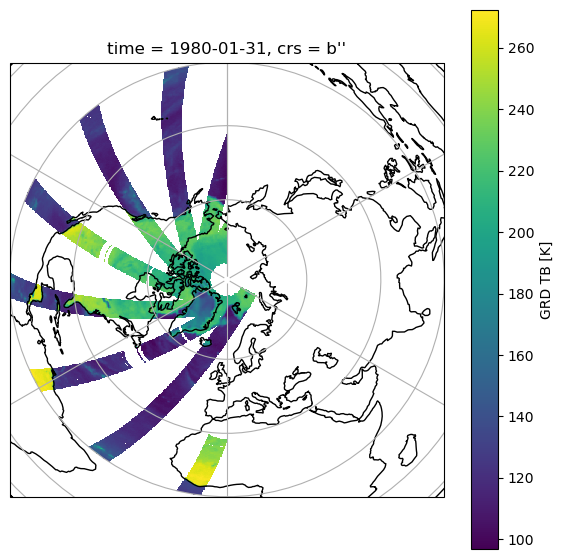

In [9]:
map_proj = ccrs.LambertAzimuthalEqualArea(central_latitude=ds.crs.attrs['latitude_of_projection_origin'], 
                                          central_longitude=ds.crs.attrs['longitude_of_projection_origin'])

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=map_proj)

ax.coastlines()
ax.gridlines()

ds.TB[0,:,:].plot(ax=ax)

The spatial resolution of the data is returned by the `rio.resolution` accessor.

In [10]:
ds.rio.resolution()

(25000.0, -25000.0)

The GeoTransform of the data, which relates image coordinates (row, column) to map coordinates (in this case x, y in meters) is returned by `rio.transform`.  This can be helpful for transforming from (row, column) coordinates to map coordinates, and the inverse.

However, if you want to extract data for a specific point or for a region, [`xarray.sel`](https://xarray-test.readthedocs.io/en/latest/indexing.html#nearest-neighbor-lookups) can be used with `method='nearest'`. 

In [11]:
ds.rio.transform()

Affine(25000.0, 0.0, -9000000.0,
       0.0, -25000.0, 9000000.0)

This returns an Affine matrix object from the `affine` package.  To transform row and column indices to map coordinates the following syntax is used:

In [12]:
col, row = (543, 231)
ds.rio.transform() * (col, row)

(4575000.0, 3225000.0)

To transform from map coordinates to image coordinates:

In [13]:
x, y = (4575000.0, 3225000.0)
~ds.rio.transform() * (x, y)

(543.0000000000001, 231.00000000000006)

The coordinates fo not have to be cell centers.  For example, finding the top-left corner point of the cell in the example above... 

In [14]:
col, row = 542.5, 230.5
ds.rio.transform() * (col, row)

(4562500.0, 3237500.0)

## Find the bounds of the dataset in latitude and longitude

The x and y bounds of the dataset are returned by `ds.rio.bounds()` as a tuple `(xmin, ymin, xmax, ymax)`.  We can use `rioxarray` to transform these bounds in projected coordinates using the [`rio.transform_bounds`](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.rioxarray.XRasterBase.transform_bounds) method.  This method is just a binding to [`rasterio.warp.transform_bounds`](https://rasterio.readthedocs.io/en/stable/api/rasterio.warp.html#rasterio.warp.transform_bounds) that returns the left, bottom, right, and top coordinates of the bounding box in the destination CRS.  The CRS can be defined as an EPSG code, WKT or proj4 string.  The result is a 4 element list.  For EPSG:4326 (WGS 84), this extent encompasses much of the Globe, down to 85 S.

_Note that an optional `USAGE` parameter may be set for a particular projection as part of the EPSG definition.  Based on [EPSG Guidance Note 7-1](https://drive.tiny.cloud/1/4m326iu12oa8re9cjiadxonharclteqb4mumfxj71zsttwkx/07cead43-4462-436c-8636-5da9531eebfd) this to is to aid searching for appropriate CRS for a given region.  To this end, the NSIDC Polar Azimuthal and Cylindrical projections all define extents, with North and South Polar projections defining extents as their respective hemispheres.  This means that while the bounding boxes returned by `rio.bounds` and `rio.transform_bounds` extend into the opposite hemisphere, these points are not considered valid._

In [15]:
ds.rio.transform_bounds('EPSG:4326')

(-180.0, -84.6340496694687, 180.0, 90.0)

If the dataset is reprojected to WGS 84, we can see that the bounds of the dataset are much of the Globe.

In [16]:
dsll = ds.TB[0,:,:].rio.reproject('EPSG:4326')

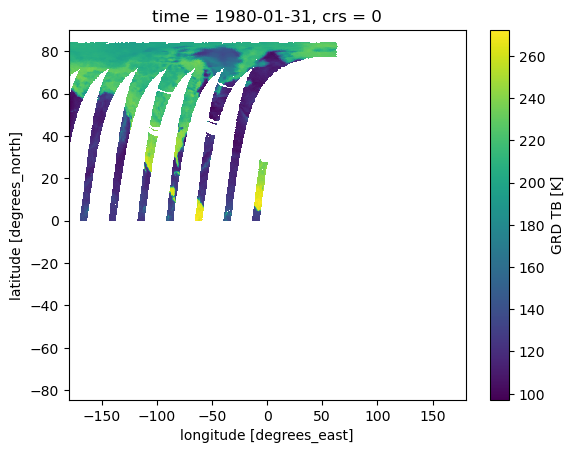

In [17]:
dsll.plot()

## Find latitude and longitude of corner points of the dataset

The bounding box returned by `rio.bounds()` returns the minima and maxima of the dataset in the two spatial coordinates.  This will be x and y in meters if the data are in a projected coordinate system, or longitude and latitude if the data are in a geographic corrdinate system.  

There may be times when we want the actual corner points of an image.  For data in a projected coordinate system, these corner cordinates will be the product of bounding box components in the x and y directions. 

For example, if the bounding box is `[xmin, ymin, xmax, ymax]`.  The coordinates of the four corners will be:

- `(xmin, ymin)`
- `(xmin, ymax)`
- `(xmax, ymax)`
- `(xmax, ymin)`

If we convert the bounding box to geographic coordinates and follow the same approach to get four corner points, the geographic coordinate pairs will not be for the same locations as the projected coordinate pairs.  To find the geographic coordinates of the four corners we can use the following workflow.



To get the `x` and `y` coordinates for the four coners we can use the `itertools.product` method.  This returns a `list` of `tuples` that are the [Cartesian Product](https://en.wikipedia.org/wiki/Cartesian_product) of the `(xmin, xmax)` and `(ymin, ymax)` of `bounds`.  

The first and third elements of `bounds` return `(xmin, xmax)`, and the second and forth elements of `bounds` return `(ymin, ymax)`.  Every nth element of a python `lists` can be accessed using the `mylist[start:end:every]` syntax.  To access `xmin` and `xmax` we use `bounds[::2]`, which returns every-other element of `bounds` starting at the first element.  To access `ymin` and `ymax` we use `bounds[1::2]`, which returns every-other element of `bounds` starting at the second element (_python is zero-indexed_).

A list-comprehension is used to generate a list of coordinate pairs as tuples for each corner.  We then use `zip(*mylist)` to split each tuple and return two tuples, one for x-coordinates of the corners and one for y-coordinates of the tuples.

_The code is much shorter than the explanation! ;)_

In [19]:
bounds = ds.rio.bounds()
x, y = zip(*[(x, y) for x, y in itertools.product(bounds[::2], bounds[1::2])])
x, y

((-9000000.0, -9000000.0, 9000000.0, 9000000.0),
 (-9000000.0, 9000000.0, -9000000.0, 9000000.0))

`rasterio.warp.transform` is then used to transform the coordinates of the corners to geographic coordinates.  The source CRS is the CRS of the original data `ds.rio.crs`.  The destination CRS is WGS 84.  We use the EPSG code `EPSG:4326`.  `rasterio` understands EPSG code passed as strings or just as numberic code, as well as other forms.

In [20]:
lon, lat = rasterio.warp.transform(ds.rio.crs, "EPSG:4326", x, y)
# Print x, y and transformed lon, lat
for xs, ys, lons, lats in zip(x, y, lon, lat):
    print(f"({xs:10.1f}, {ys:10.1f}) -> ({lons:8.3f}, {lats:8.3f})") 

(-9000000.0, -9000000.0) -> ( -45.000,  -84.634)
(-9000000.0,  9000000.0) -> (-135.000,  -84.634)
( 9000000.0, -9000000.0) -> (  45.000,  -84.634)
( 9000000.0,  9000000.0) -> ( 135.000,  -84.634)


The corner points can be visualized, just to check.

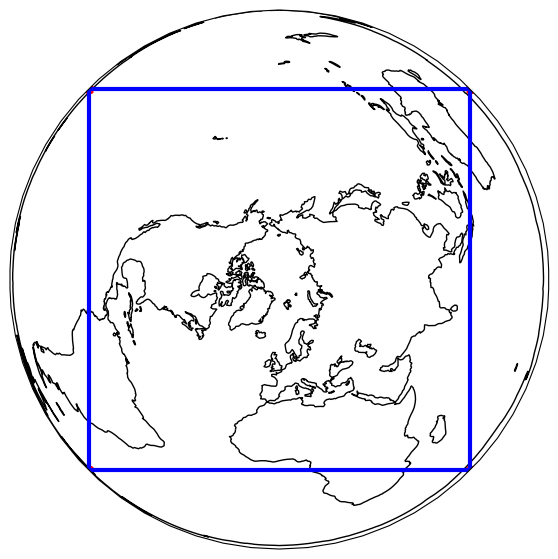

In [22]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(projection=map_proj)
ax.set_extent([-180., 180., -88., 90.], ccrs.PlateCarree())

ax.coastlines()
ax.scatter(lon, lat, color='red', marker='+', linewidths=5, transform=ccrs.PlateCarree())
ax.plot([x[i] for i in order], [y[i] for i in order], 'b-', lw=3)  # x and y are reordered to plot a square

## To Add

- Generate lat-lon grid
- command line option for getting bounds
- clo for getting bounds in lat-lon
- clo for generating ll grid

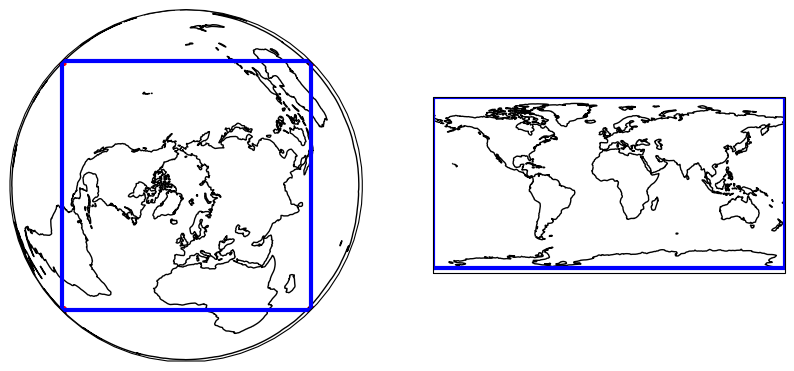

In [43]:
llbnds = ds.rio.transform_bounds('EPSG:4326')
blon, blat = zip(*[(x, y) for x, y in itertools.product(llbnds[::2], llbnds[1::2])])

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(121, projection=map_proj)
ax1.set_extent([-180., 180., -89.9999, 90.], ccrs.PlateCarree())

ax1.coastlines()
ax1.scatter(lon, lat, color='red', marker='+', linewidths=5, transform=ccrs.PlateCarree())
ax1.plot([x[i] for i in order], [y[i] for i in order], 'b-', lw=3)  # x and y are reordered to plot a square

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
ax2.set_extent([-180., 180., -90., 90.], ccrs.PlateCarree())

ax2.coastlines()
ax2.plot([blon[i] for i in order], [blat[i] for i in order], 'b-', lw=3)  # x and y are reordered to plot a square

fig.savefig('geospatial_bounds_0630.png')